In [1]:
import torch
import matplotlib
import torch.nn as nn

In [41]:
Q = torch.tensor([
    [0.,0.,0.,.0],
    [.1,0.,.1,0.],
    [.1,.1,0.,.1],
    [.1,.3,0.,.2],
])
K = torch.tensor([.04,0.08,0.,0.9])
V = torch.tensor([1.,1.,1.,1.])
dk_sqrt = torch.sqrt(torch.tensor(Q.shape[0]))

energy = torch.softmax((Q@K.t()) / dk_sqrt, dim=0)
(Q@K.t()), energy

(tensor([0.0000, 0.0040, 0.1020, 0.2080]),
 tensor([0.2402, 0.2406, 0.2527, 0.2665]))

In [153]:
class Attention(nn.Module):
    
    def __init__(self, dims, heads):
        
        super(Attention, self).__init__()
        
        self.dims = dims
        self.heads = heads
        self.hidden = dims * heads
        self.q = nn.Linear(self.hidden, self.hidden)
        self.k = nn.Linear(self.hidden, self.hidden)
        self.v = nn.Linear(self.hidden, self.hidden)
        
        self.dk_sqrt = torch.sqrt(torch.tensor(dims))
        
        self.out_projection = nn.Linear(self.hidden, self.dims)
        
    def forward(self, x):
        
        xr = x.repeat(self.heads)
        
        qs = self.q(xr)
        ks = self.k(xr)
        vs = self.v(xr)
        
        energy = (qs@ks.t()) / self.dk_sqrt
        energy = torch.softmax(energy, dim=-1)
        
        attention = (vs * energy)
        
        return self.out_projection(attention)
    
class MLP(nn.Module):
    
    def __init__(self, in_dims, hidden):
        
        super(MLP, self).__init__()
        
        self.lin1 = nn.Linear(in_dims, hidden)
        self.lin2 = nn.Linear(hidden, in_dims)
    
    def forward(self, x):
        
        o = torch.sigmoid(self.lin1(x))
        o = torch.softmax(self.lin2(o), dim=-1)
        
        return o
    
m = Attention(3,3)
m(torch.tensor([1.,2.,3.]))

tensor([-0.5581,  0.3110,  0.9848], grad_fn=<AddBackward0>)

In [172]:
xs = torch.randn((500, 3))
ys = torch.argmax(xs, dim=1)

model = Attention(3, 3)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

for i in range(6000):
    model.zero_grad()
    ni = i % xs.shape[0]
    batch = xs[ni]
    logits = model(batch)
    loss = criterion(logits, ys[ni])
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(loss.item())

1.74131441116333
0.08093179762363434
0.022563748061656952
0.008194752037525177
0.0034644128754734993
0.0016183863626793027


tensor([10.,  1.,  3., 10.,  1.,  3., 10.,  1.,  3.])


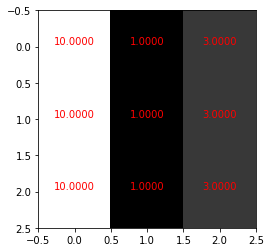

In [210]:
x_in = torch.tensor([10.,1.,3.]).repeat(3)

def attention_display(x, w, h):
    print(x)
    plt.imshow(x.detach()[None,...].view(w,h), cmap='gray')
    for j in range(x.shape[0]):
        plt.text(j % w, j // h, f'{x[j].item():.4f}', ha="center", va="bottom", color="red")

attention_display(x_in, 3, 3)

tensor([-0.2890,  1.4123, -4.3029,  5.8278,  0.1288,  3.3910,  1.0047,  0.4831,
         1.1907], grad_fn=<AddBackward0>)


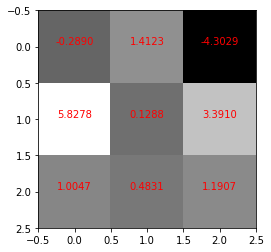

In [211]:
import matplotlib.pyplot as plt

qs = model.q(x_in)
ks = model.k(x_in)
vs = model.v(x_in)
        
attention_display(qs, 3, 3)

tensor([-6.0057,  1.6199, -2.2467, -1.5928,  3.5710,  7.2502, -5.3089, -3.3371,
         1.8036], grad_fn=<AddBackward0>)


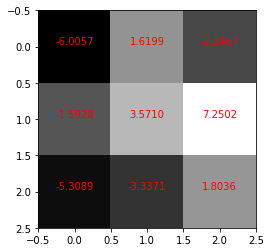

In [212]:
attention_display(ks, 3, 3)

tensor([13.3727, -8.3064, -9.7089,  7.6738, 11.6818, 10.0033, 19.0327, 10.4102,
        10.1479], grad_fn=<AddBackward0>)


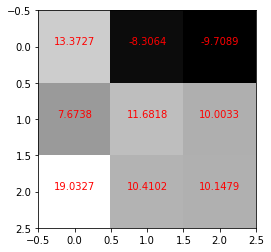

In [213]:
attention_display(vs, 3, 3)

tensor([  7.9042, -14.8343,  -6.3160, -24.4852,   9.1005, -14.5798,  -4.5763,
          5.0560,  -2.7704], grad_fn=<ViewBackward0>)


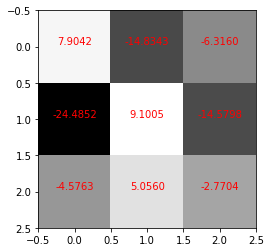

In [227]:
energy = qs.view(3,3)@ks.view(3,3).t() / model.dk_sqrt
attention_display(energy.view(-1), 3, 3)

In [215]:
sm_energy = torch.softmax(energy, dim=-1)
print(sm_energy)

tensor(1., grad_fn=<SoftmaxBackward0>)


tensor([13.3727, -8.3064, -9.7089,  7.6738, 11.6818, 10.0033, 19.0327, 10.4102,
        10.1479], grad_fn=<MulBackward0>)


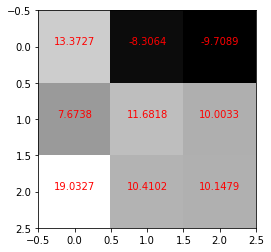

In [216]:
attention = sm_energy * vs
attention_display(attention, 3, 3)

tensor([-0.2890,  1.4123, -4.3029,  5.8278,  0.1288,  3.3910,  1.0047,  0.4831,
         1.1907], grad_fn=<AddBackward0>)


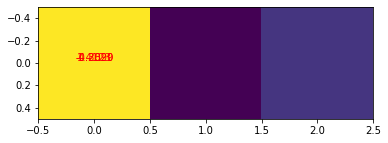

In [199]:
logits = model.out_projection(attention)
attention_display(logits, 1, 3)

In [323]:
import copy
import math
import torch.functional as F

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = torch.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)
    
m = MultiHeadedAttention(3, 3)
xxs = torch.randn(1,2,3)
m(xxs, xxs, xxs).shape
m.linears[0].weight

Parameter containing:
tensor([[-0.1093,  0.3450, -0.5085],
        [-0.2263, -0.3071,  0.0324],
        [-0.1063, -0.5718, -0.0518]], requires_grad=True)

In [328]:
query, key, value = \
            [l(x).view(xxs.shape[0], -1, m.h, m.d_k).transpose(1, 2)
             for l, x in zip(m.linears, (xxs, xxs, xxs))]

In [329]:
m.linears[0](xxs)

tensor([[[ 0.0881, -0.0493,  0.0510],
         [ 0.0753,  0.2720, -0.2351]]], grad_fn=<AddBackward0>)

In [330]:
s1 = m.linears[0](xxs).view(xxs.shape[0], -1, m.h, m.d_k)
s1, s1.shape

(tensor([[[[ 0.0881],
           [-0.0493],
           [ 0.0510]],
 
          [[ 0.0753],
           [ 0.2720],
           [-0.2351]]]], grad_fn=<ViewBackward0>),
 torch.Size([1, 2, 3, 1]))

In [331]:
s2 = s1.transpose(1, 2)
s2, s2.shape

(tensor([[[[ 0.0881],
           [ 0.0753]],
 
          [[-0.0493],
           [ 0.2720]],
 
          [[ 0.0510],
           [-0.2351]]]], grad_fn=<TransposeBackward0>),
 torch.Size([1, 3, 2, 1]))

In [332]:
xxs.shape, query.shape, key.shape, value.shape

(torch.Size([1, 2, 3]),
 torch.Size([1, 3, 2, 1]),
 torch.Size([1, 3, 2, 1]),
 torch.Size([1, 3, 2, 1]))

In [333]:
query

tensor([[[[ 0.0881],
          [ 0.0753]],

         [[-0.0493],
          [ 0.2720]],

         [[ 0.0510],
          [-0.2351]]]], grad_fn=<TransposeBackward0>)

In [334]:
x, attn = attention(query, key, value, mask=None, dropout=None)
x, attn

(tensor([[[[ 0.0817],
           [ 0.0817]],
 
          [[ 0.1101],
           [ 0.1184]],
 
          [[-0.0910],
           [-0.0969]]]], grad_fn=<UnsafeViewBackward0>),
 tensor([[[[0.5003, 0.4997],
           [0.5002, 0.4998]],
 
          [[0.5040, 0.4960],
           [0.4782, 0.5218]],
 
          [[0.5036, 0.4964],
           [0.4832, 0.5168]]]], grad_fn=<SoftmaxBackward0>))

In [335]:
x.transpose(1, 2).contiguous()

tensor([[[[ 0.0817],
          [ 0.1101],
          [-0.0910]],

         [[ 0.0817],
          [ 0.1184],
          [-0.0969]]]], grad_fn=<CloneBackward0>)

In [337]:
xc = x.transpose(1, 2).contiguous().view(xxs.shape[0], -1, m.h * m.d_k)
xc

tensor([[[ 0.0817,  0.1101, -0.0910],
         [ 0.0817,  0.1184, -0.0969]]], grad_fn=<ViewBackward0>)

In [338]:
m.linears[-1](xc)

tensor([[[ 0.2168,  0.0308, -0.3662],
         [ 0.2227,  0.0280, -0.3706]]], grad_fn=<AddBackward0>)

In [357]:
import json
torch.randn((1,2,3,4)).transpose(0,3),torch.randn((1,2,3,4))

(tensor([[[[ 0.4465],
           [-1.1654],
           [ 0.3854]],
 
          [[ 0.2602],
           [ 0.8099],
           [ 0.9536]]],
 
 
         [[[ 0.8053],
           [-0.8115],
           [-0.3507]],
 
          [[ 1.6561],
           [-1.0229],
           [-0.8902]]],
 
 
         [[[-1.7839],
           [-0.6346],
           [-0.9602]],
 
          [[-0.5324],
           [-0.3269],
           [ 1.0481]]],
 
 
         [[[ 0.0984],
           [-1.3396],
           [-0.7955]],
 
          [[ 0.7466],
           [-0.4345],
           [-1.5201]]]]),
 tensor([[[[-0.5250, -0.7298,  1.1274, -2.0542],
           [ 0.0826,  0.0988, -0.5345, -0.1224],
           [ 1.8959, -0.3618,  0.1356, -0.7332]],
 
          [[ 0.6610,  0.3381, -0.2620,  0.2208],
           [ 0.9009, -1.0438, -1.0590,  1.4567],
           [-1.1625,  0.9670, -0.4196, -0.0286]]]]))

In [35]:
a = (torch.arange(300) / 100).int().view(-1,10,10)
b = (torch.arange(400, 700)).int().view(-1,10,10)
b, b.transpose(-2,-1)

(tensor([[[400, 401, 402, 403, 404, 405, 406, 407, 408, 409],
          [410, 411, 412, 413, 414, 415, 416, 417, 418, 419],
          [420, 421, 422, 423, 424, 425, 426, 427, 428, 429],
          [430, 431, 432, 433, 434, 435, 436, 437, 438, 439],
          [440, 441, 442, 443, 444, 445, 446, 447, 448, 449],
          [450, 451, 452, 453, 454, 455, 456, 457, 458, 459],
          [460, 461, 462, 463, 464, 465, 466, 467, 468, 469],
          [470, 471, 472, 473, 474, 475, 476, 477, 478, 479],
          [480, 481, 482, 483, 484, 485, 486, 487, 488, 489],
          [490, 491, 492, 493, 494, 495, 496, 497, 498, 499]],
 
         [[500, 501, 502, 503, 504, 505, 506, 507, 508, 509],
          [510, 511, 512, 513, 514, 515, 516, 517, 518, 519],
          [520, 521, 522, 523, 524, 525, 526, 527, 528, 529],
          [530, 531, 532, 533, 534, 535, 536, 537, 538, 539],
          [540, 541, 542, 543, 544, 545, 546, 547, 548, 549],
          [550, 551, 552, 553, 554, 555, 556, 557, 558, 559],
     